In [9]:
import numpy as np
from matplotlib import pyplot as plt

In [10]:
plt.style.use('seaborn-v0_8-whitegrid')

In [11]:
%matplotlib inline

In [12]:
from rsnn.spike_train.sampler import sample_spike_trains
from rsnn.spike_train.utils import check_refractoriness

## Accept/Reject Sampling for Jittered Spike Trains

The rejection probability increases exponentially with $\sigma$.

In [29]:
num_neurons = 10000
period, firing_rate = 100, 0.2
spike_trains = sample_spike_trains(period, firing_rate, num_neurons)

sigmas = np.linspace(0,1,20)

In [27]:
num_rejections = []
for sigma in sigmas:
    num_rejections.append(0)
    jitter_dist = lambda size: np.random.normal(0, sigma, size)
    for firing_times in spike_trains:
        while True:
            tmp_firing_times = firing_times + jitter_dist(firing_times.size)
            if np.all(tmp_firing_times >= 0) and np.all(tmp_firing_times < period) and check_refractoriness(tmp_firing_times):
                break
            num_rejections[-1] += 1/num_neurons

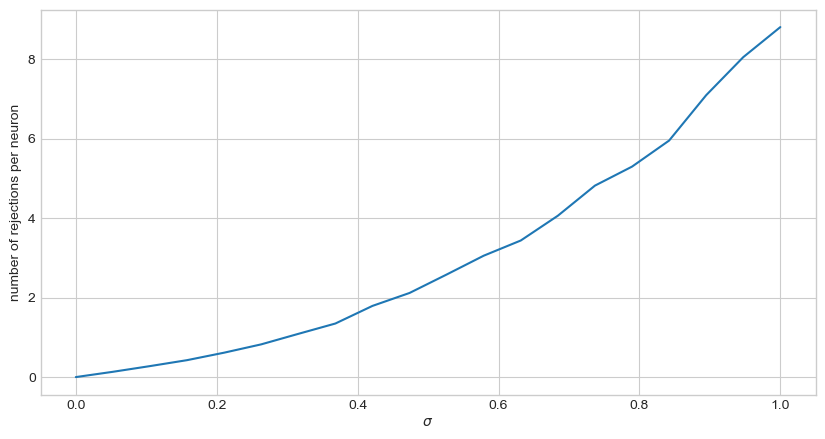

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
    
ax.plot(sigmas, num_rejections)

ax.set_xlabel("$\sigma$")
ax.set_ylabel("number of rejections per neuron")

plt.show()

The rejection probability should increase exponentially with the period

In [34]:
num_neurons = 10000
firing_rate = 0.2

sigma = 0.2
jitter_dist = lambda size: np.random.normal(0, sigma, size)

In [35]:
periods = np.linspace(50,500,20)

num_rejections = []
for period in periods:
    spike_trains = sample_spike_trains(period, firing_rate, num_neurons)

    num_rejections.append(0)
    
    for firing_times in spike_trains:
        while True:
            tmp_firing_times = firing_times + jitter_dist(firing_times.size)
            if np.all(tmp_firing_times >= 0) and np.all(tmp_firing_times < period) and check_refractoriness(tmp_firing_times):
                break
            num_rejections[-1] += 1/num_neurons

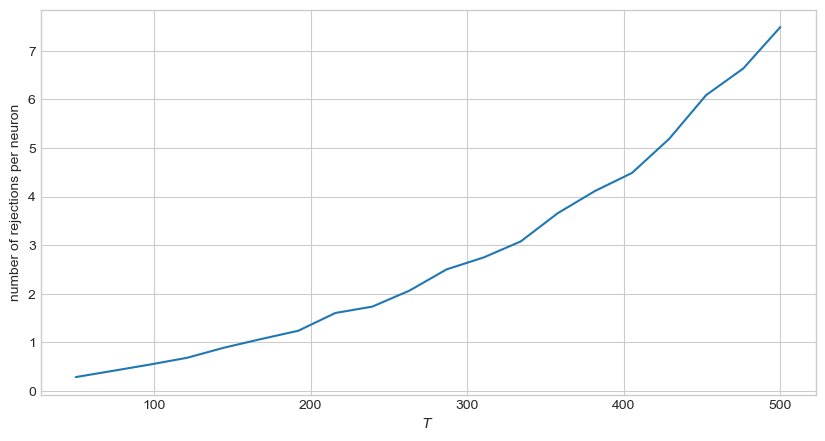

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
    
ax.plot(periods, num_rejections)

ax.set_xlabel("$T$")
ax.set_ylabel("number of rejections per neuron")

plt.show()